In [1]:
!pip install -q 'tensorflow-text==2.15.*'
!pip index versions tensorflow-text

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
tensorflow-text (2.17.0)
Available versions: 2.17.0, 2.16.1, 2.15.0, 2.14.0, 2.13.0, 2.12.1, 2.12.0, 2.11.0, 2.10.0, 2.9.0, 2.8.2, 2.8.1
  INSTALLED: 2.15.0
  LATEST:    2.17.0


In [2]:
import string
import numpy as np
import pandas as pd
from numpy import array
from pickle import load

from PIL import Image
import pickle
from collections import Counter
import matplotlib.pyplot as plt

import sys, time, os, warnings
warnings.filterwarnings("ignore")
import re

import keras
import tensorflow as tf
from tqdm import tqdm
from nltk.translate.bleu_score import sentence_bleu

from keras.utils import pad_sequences
from keras.utils import load_img
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, BatchNormalization
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers import add
from keras.callbacks import ModelCheckpoint
from keras.utils import img_to_array
#from keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.applications.convnext import ConvNeXtTiny, preprocess_input


from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

2024-08-21 20:25:32.526443: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-21 20:25:32.526536: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-21 20:25:32.661124: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
image_path = "/kaggle/input/flickr8k/Images"
data = pd.read_csv("/kaggle/input/bancap/BAN-Cap_captiondata.csv")
jpgs = os.listdir(image_path)
print("Total Images in Dataset = {}".format(len(jpgs)))
print(type(data))
data

Total Images in Dataset = 8091
<class 'pandas.core.frame.DataFrame'>


caption_id  \
0      1000268201_693b08cb0e.jpg#0   
1      1000268201_693b08cb0e.jpg#1   
2      1000268201_693b08cb0e.jpg#2   
3      1000268201_693b08cb0e.jpg#3   
4      1000268201_693b08cb0e.jpg#4   
...                            ...   
40450   997722733_0cb5439472.jpg#0   
40451   997722733_0cb5439472.jpg#1   
40452   997722733_0cb5439472.jpg#2   
40453   997722733_0cb5439472.jpg#3   
40454   997722733_0cb5439472.jpg#4   

                                         english_caption  \
0      A child in a pink dress is climbing up a set o...   
1                  A girl going into a wooden building .   
2       A little girl climbing into a wooden playhouse .   
3      A little girl climbing the stairs to her playh...   
4      A little girl in a pink dress going into a woo...   
...                                                  ...   
40450           A man in a pink shirt climbs a rock face   
40451           A man is rock climbing high in the air .   
40452  A person in a red shirt climbing up a rock fac...   
40453                    A rock climber in a red shirt .   
40454  A rock climber practices on a rock climbing wa...   

                                         bengali_caption  
0      একটি গোলাপী জামা পরা বাচ্চা মেয়ে একটি বাড়ির প্...  
1                 একটি মেয়ে শিশু একটি কাঠের বাড়িতে ঢুকছে  
2                   একটি বাচ্চা তার কাঠের খেলাঘরে উঠছে ।  
3               ছোট মেয়েটি তার খেলার ঘরের সিড়ি বেয়ে উঠছে  
4      গোলাপি জামা পড়া ছোট একটি মেয়ে একটি কাঠের তৈরি...  
...                                                  ...  
40450     গোলাপী শার্টের একটি লোক একটি শিলার উপরে উঠেছিল  
40451                    একজন মানুষ পাথরে চড়ছে অনেক উপরে  
40452  লাল শার্টের একজন ব্যক্তি সহায়তার হাতলগুলিতে ঢ...  
40453                           লাল শার্টে একটি রক আরোহী  
40454  একটি রক আরোহী একটি শৈল আরোহণ প্রাচীর এর উপর অন...  

[40455 rows x 3 columns]

In [4]:
data['caption_id']=data['caption_id'].str[:-2]
data=data.drop('english_caption',axis=1)
data.rename(columns = {'caption_id':'filename','bengali_caption':'caption'}, inplace = True)
uni_filenames = np.unique(data.filename.values)
data.head()

filename  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  একটি গোলাপী জামা পরা বাচ্চা মেয়ে একটি বাড়ির প্...  
1             একটি মেয়ে শিশু একটি কাঠের বাড়িতে ঢুকছে  
2               একটি বাচ্চা তার কাঠের খেলাঘরে উঠছে ।  
3           ছোট মেয়েটি তার খেলার ঘরের সিড়ি বেয়ে উঠছে  
4  গোলাপি জামা পড়া ছোট একটি মেয়ে একটি কাঠের তৈরি...

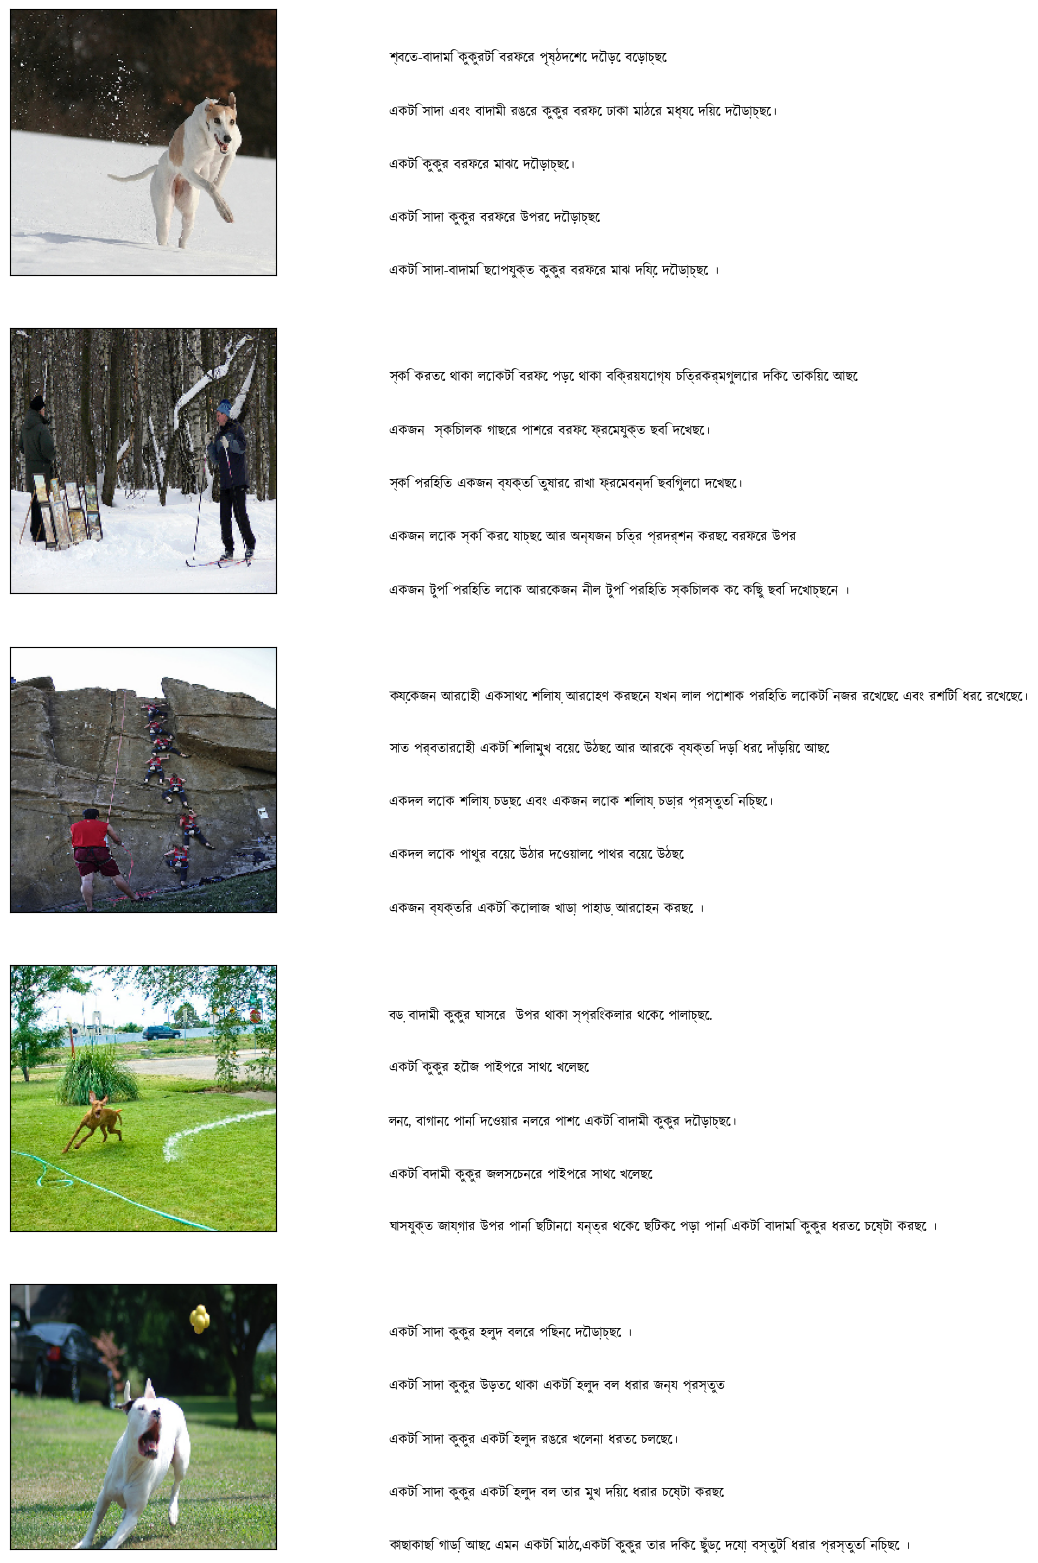

In [5]:
from matplotlib import font_manager
bangla_font_path = "/kaggle/input/kalpurush/kalpurush.ttf"  # Provide the path to your installed Bangla font
bangla_font_prop = font_manager.FontProperties(fname=bangla_font_path)
npic = 5
npix = 224
target_size = (npix,npix,3)
count = 1

fig = plt.figure(figsize=(10,20))
for jpgfnm in uni_filenames[10:15]:
    filename = image_path + '/' + jpgfnm
    captions = list(data["caption"].loc[data["filename"]==jpgfnm].values)
    image_load = load_img(filename, target_size=target_size)
    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1

    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,len(captions))
    for i, caption in enumerate(captions):
        ax.text(0,i,caption,fontproperties=bangla_font_prop)
    count += 1
plt.show()

In [6]:
uni_filenames = np.unique(data.filename.values)
data.head()

filename  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  একটি গোলাপী জামা পরা বাচ্চা মেয়ে একটি বাড়ির প্...  
1             একটি মেয়ে শিশু একটি কাঠের বাড়িতে ঢুকছে  
2               একটি বাচ্চা তার কাঠের খেলাঘরে উঠছে ।  
3           ছোট মেয়েটি তার খেলার ঘরের সিড়ি বেয়ে উঠছে  
4  গোলাপি জামা পড়া ছোট একটি মেয়ে একটি কাঠের তৈরি...

In [7]:
vocabulary = []
for txt in data.caption.values:
    vocabulary.extend(txt.split())
print('Vocabulary Size: %d' % len(set(vocabulary)))
print(len(vocabulary))

Vocabulary Size: 17351
346511


In [8]:
for i in vocabulary:
    if len(i)<2:
        vocabulary.remove(i)
vocabulary=set(vocabulary)
print(len(vocabulary))

17325


In [9]:
PATH = "/kaggle/working/images/"
all_captions = []
for caption  in data['caption']:
    caption = '<start> ' + caption+ ' <end>'
    all_captions.append(caption)

all_captions[:10]
if not os.path.exists(PATH):
    os.makedirs(PATH)

In [10]:
import shutil

In [11]:
all_img_name_vector = []
for annot in data["filename"]:
    filename = annot
    source_path = '/kaggle/input/flickr8k/Images/' + filename
    destination_path = '/kaggle/working/images/' + filename
    shutil.copyfile(source_path, destination_path)
    
    full_image_path = PATH + annot
    all_img_name_vector.append(full_image_path)
    
all_img_name_vector[:10]

['/kaggle/working/images/1000268201_693b08cb0e.jpg',
 '/kaggle/working/images/1000268201_693b08cb0e.jpg',
 '/kaggle/working/images/1000268201_693b08cb0e.jpg',
 '/kaggle/working/images/1000268201_693b08cb0e.jpg',
 '/kaggle/working/images/1000268201_693b08cb0e.jpg',
 '/kaggle/working/images/1001773457_577c3a7d70.jpg',
 '/kaggle/working/images/1001773457_577c3a7d70.jpg',
 '/kaggle/working/images/1001773457_577c3a7d70.jpg',
 '/kaggle/working/images/1001773457_577c3a7d70.jpg',
 '/kaggle/working/images/1001773457_577c3a7d70.jpg']

In [12]:
print(f"len(all_img_name_vector) : {len(all_img_name_vector)}")
print(f"len(all_captions) : {len(all_captions)}")

len(all_img_name_vector) : 40455
len(all_captions) : 40455


In [13]:
def data_limiter(num,total_captions,all_img_name_vector):
    train_captions, img_name_vector = shuffle(total_captions,all_img_name_vector,random_state=1)
    train_captions = train_captions[:num]
    img_name_vector = img_name_vector[:num]
    return train_captions,img_name_vector

train_captions,img_name_vector = data_limiter(40000,all_captions,all_img_name_vector)

In [14]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224, 224))  # ConvNeXt typically uses 224x224 input size
    img = preprocess_input(img)  # Use preprocess_input from ConvNeXt
    return img, image_path

# Load the ConvNeXt-Tiny model
image_model = ConvNeXtTiny(include_top=False, weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

111650432/111650432 [==============================] - 1s 0us/step


In [15]:
encode_train = sorted(set(img_name_vector))
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(64)

In [16]:
%%time
for img, path in tqdm(image_dataset):
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features,
                             (batch_features.shape[0], -1, batch_features.shape[3]))

    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        np.save(path_of_feature, bf.numpy())

  0%|          | 0/127 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1724272050.754665      25 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
100%|██████████| 127/127 [01:08<00:00,  1.86it/s]

CPU times: user 1min 31s, sys: 2.93 s, total: 1min 34s
Wall time: 1min 8s


In [17]:
top_k = 12000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                 oov_token="<unk>",
                                                 filters='!"#$%&()*+.,-/:;=?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'
max_length=25
train_seqs = tokenizer.texts_to_sequences(train_captions)
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post',maxlen=max_length)
#Let’s visualize the padded training and captions and the tokenized vectors:

train_captions[:3]
print(cap_vector[0])
print(len(cap_vector[0]))

[   2   60   31 1094   83    4  620 2196  126   19    3    0    0    0
    0    0    0    0    0    0    0    0    0    0    0]
25


In [18]:
train_seqs[:3]

[[2, 60, 31, 1094, 83, 4, 620, 2196, 126, 19, 3],
 [2, 5, 182, 888, 1047, 11, 10, 8003, 2672, 1332, 166, 3],
 [2, 4, 13, 6, 80, 129, 40, 1708, 37, 120, 3]]

In [19]:
def calc_max_length(tensor):
    return max(len(t) for t in tensor)
max_length = calc_max_length(train_seqs)
max_length=25
def calc_min_length(tensor):
    return min(len(t) for t in tensor)
min_length = calc_min_length(train_seqs)

print('Max Length of any caption : Min Length of any caption = '+ str(max_length) +" : "+str(min_length))

Max Length of any caption : Min Length of any caption = 25 : 4


In [20]:
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,cap_vector, test_size=0.02, random_state=0)

In [21]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
num_steps = len(img_name_train) // BATCH_SIZE

def map_func(img_name, cap):
    img_tensor = np.load(img_name.decode('utf-8')+'.npy')
    return img_tensor, cap

dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))
dataset = dataset.map(lambda item1, item2: tf.numpy_function(map_func, [item1, item2], [tf.float32, tf.int32]),num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [22]:
#num_steps = len(img_name_val) // BATCH_SIZE
val_dataset = tf.data.Dataset.from_tensor_slices((img_name_val, cap_val))
val_dataset = val_dataset.map(lambda item1, item2: tf.numpy_function(map_func, [item1, item2], [tf.float32, tf.int32]), num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [23]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding_1d(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                           np.arange(d_model)[np.newaxis, :],
                           d_model)

    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

def positional_encoding_2d(row,col,d_model):
    assert d_model % 2 == 0
    row_pos = np.repeat(np.arange(row),col)[:,np.newaxis]
    col_pos = np.repeat(np.expand_dims(np.arange(col),0),row,axis=0).reshape(-1,1)

    angle_rads_row = get_angles(row_pos,np.arange(d_model//2)[np.newaxis,:],d_model//2)
    angle_rads_col = get_angles(col_pos,np.arange(d_model//2)[np.newaxis,:],d_model//2)

    angle_rads_row[:, 0::2] = np.sin(angle_rads_row[:, 0::2])
    angle_rads_row[:, 1::2] = np.cos(angle_rads_row[:, 1::2])
    angle_rads_col[:, 0::2] = np.sin(angle_rads_col[:, 0::2])
    angle_rads_col[:, 1::2] = np.cos(angle_rads_col[:, 1::2])
    pos_encoding = np.concatenate([angle_rads_row,angle_rads_col],axis=1)[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

In [24]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
    if mask is not None:
        scaled_attention_logits += (mask * -1e9) 
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1) 
    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)
#     print(output.shape)
#     image =array_to_img(output)
#     image.show()
    return output, attention_weights

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        assert d_model % self.num_heads == 0
        self.depth = d_model // self.num_heads
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask=None):
        batch_size = tf.shape(q)[0]
        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q,      num_heads, depth)

        concat_attention = tf.reshape(scaled_attention,(batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        return output, attention_weights

def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
                tf.keras.layers.Dense(dff, activation='relu'),tf.keras.layers.Dense(d_model)])# (batch_size, seq_len, d_model)])

In [25]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.001):
        super(EncoderLayer, self).__init__()
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)


    def call(self, x, training, mask=None):
        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
        return out2
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.001):
        super(DecoderLayer, self).__init__()
        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training,look_ahead_mask=None, padding_mask=None):
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask) 
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)
        return out3, attn_weights_block1, attn_weights_block2

In [26]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, row_size,col_size,rate=0.001):
        super(Encoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Dense(self.d_model,activation='relu')
        self.pos_encoding = positional_encoding_2d(row_size,col_size,self.d_model)

        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask=None):
        seq_len = tf.shape(x)[1]
        x = self.embedding(x)  # (batch_size, input_seq_len(H*W), d_model)
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)

        return x  # (batch_size, input_seq_len, d_model)
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers,d_model,num_heads,dff, target_vocab_size, maximum_position_encoding,   rate=0.001):
        super(Decoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding_1d(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate)
                         for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training,look_ahead_mask=None, padding_mask=None):
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                            look_ahead_mask, padding_mask)
         
            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
        return x, attention_weights

In [27]:
import time

In [28]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff,row_size,col_size,
              target_vocab_size,max_pos_encoding, rate=0.001):
        super(Transformer, self).__init__()
        self.encoder = Encoder(num_layers, d_model, num_heads, dff,row_size,col_size, rate)
        self.decoder = Decoder(num_layers, d_model, num_heads, dff,target_vocab_size,max_pos_encoding, rate)
        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, inp, tar, training,look_ahead_mask=None,dec_padding_mask=None,enc_padding_mask=None   ):
        enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model      )
        dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)
        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
        return final_output, attention_weights

In [29]:
num_layer = 8
d_model = 512
dff = 2048
num_heads = 8
row_size = 8
col_size = 8
target_vocab_size = top_k + 1
dropout_rate = 0.001
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        self.warmup_steps = warmup_steps
    def __call__(self, step):
        step = tf.cast(step, tf.float32)  
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        #print(tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2))
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                    epsilon=1e-9)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

val_loss = tf.keras.metrics.Mean(name='val_loss')
val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy')

transformer = Transformer(num_layer,d_model,num_heads,dff,row_size,col_size,target_vocab_size,max_pos_encoding=target_vocab_size,rate=dropout_rate)

In [30]:
def create_masks_decoder(tar):
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
    return combined_mask
@tf.function
def train_step(img_tensor, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]
    dec_mask = create_masks_decoder(tar_inp)
    with tf.GradientTape() as tape:
        predictions, _ = transformer(img_tensor, tar_inp,True, dec_mask)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)   
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
    train_loss(loss)
    train_accuracy(tar_real, predictions)
    
def valid_step(img_tensor, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]
    dec_mask = create_masks_decoder(tar_inp)
    with tf.GradientTape() as tape:
        val_predictions, _ = transformer(img_tensor, tar_inp,True, dec_mask)
        val_loss_value = loss_function(tar_real, val_predictions)
    val_loss(val_loss_value)
    val_accuracy(tar_real, val_predictions)

train_accuracy_values = []
train_loss_values=[]
val_accuracy_values = []
val_loss_values=[]
for epoch in range(100):
    start = time.time()
    train_loss.reset_states()
    train_accuracy.reset_states()
    val_loss.reset_states()
    val_accuracy.reset_states()
    for (batch, (img_tensor, tar)) in enumerate(dataset):
        train_step(img_tensor, tar)
        if batch % 50 == 0:
            print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
         epoch + 1, batch, train_loss.result(), train_accuracy.result()))
    # Validation loop
    for (batch, (val_img_tensor, val_tar)) in enumerate(val_dataset):
        valid_step(img_tensor, tar)

    
    train_accuracy_values.append(train_accuracy.result())
    train_loss_values.append(train_loss.result())
    val_accuracy_values.append(val_accuracy.result())
    val_loss_values.append(val_loss.result())
    
    print('Epoch {} Loss {:.4f} Accuracy {:.4f} Val Loss {:.4f} Val Accuracy {:.4f}'.format(
        epoch + 1, train_loss.result(), train_accuracy.result(), val_loss.result(), val_accuracy.result()))
    print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 9.3417 Accuracy 0.0000
Epoch 1 Batch 50 Loss 8.9944 Accuracy 0.0328
Epoch 1 Batch 100 Loss 8.6927 Accuracy 0.0372
Epoch 1 Batch 150 Loss 8.4221 Accuracy 0.0430
Epoch 1 Batch 200 Loss 8.1359 Accuracy 0.0472
Epoch 1 Batch 250 Loss 7.8397 Accuracy 0.0498
Epoch 1 Batch 300 Loss 7.5643 Accuracy 0.0522
Epoch 1 Batch 350 Loss 7.3318 Accuracy 0.0545
Epoch 1 Batch 400 Loss 7.1328 Accuracy 0.0570
Epoch 1 Batch 450 Loss 6.9647 Accuracy 0.0592
Epoch 1 Batch 500 Loss 6.8134 Accuracy 0.0615
Epoch 1 Batch 550 Loss 6.6778 Accuracy 0.0635
Epoch 1 Batch 600 Loss 6.5572 Accuracy 0.0655
Epoch 1 Loss 6.5296 Accuracy 0.0659 Val Loss 5.2220 Val Accuracy 0.0862
Time taken for 1 epoch: 295.08798718452454 secs

Epoch 2 Batch 0 Loss 5.1155 Accuracy 0.0951
Epoch 2 Batch 50 Loss 5.1168 Accuracy 0.0902
Epoch 2 Batch 100 Loss 5.0691 Accuracy 0.0917
Epoch 2 Batch 150 Loss 5.0246 Accuracy 0.0928
Epoch 2 Batch 200 Loss 4.9829 Accuracy 0.0944
Epoch 2 Batch 250 Loss 4.9364 Accuracy 0.0956
Epoch 2 Bat

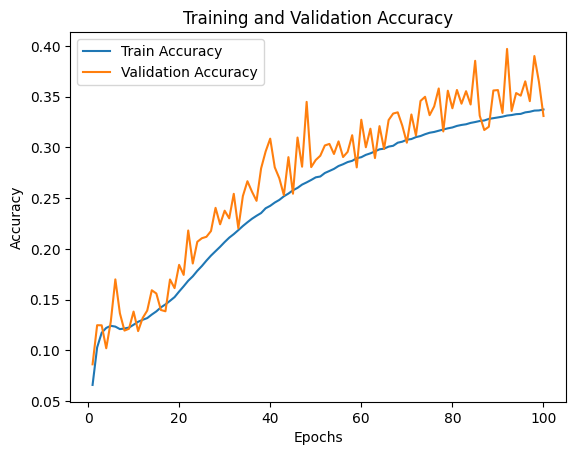

In [31]:
# Plotting the accuracy values
num_epochs=100
epochs = range(1, num_epochs + 1)
plt.plot(epochs, train_accuracy_values, label='Train Accuracy')
plt.plot(epochs, val_accuracy_values, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

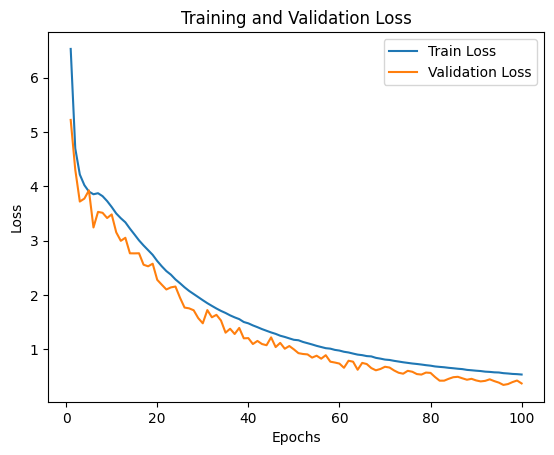

In [32]:
# Plotting the accuracy values
num_epochs=100
epochs = range(1, num_epochs + 1)
plt.plot(epochs, train_loss_values, label='Train Loss')
plt.plot(epochs, val_loss_values, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [33]:
def evaluate(image):
    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
    start_token = tokenizer.word_index['<start>']
    end_token = tokenizer.word_index['<end>']
    decoder_input = [start_token]
    output = tf.expand_dims(decoder_input, 0) #tokens
    result = [] #word list
    attention_weights_list = []  # List to store attention weights
    for i in range(100):
        dec_mask = create_masks_decoder(output)
        predictions, attention_weights = transformer(img_tensor_val,output,False,dec_mask)
        predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
        if predicted_id == end_token:
            return result,tf.squeeze(output, axis=0), attention_weights_list
        result.append(tokenizer.index_word[int(predicted_id)])
        output = tf.concat([output, predicted_id], axis=-1)
        # Store the attention weights for this step
        attention_weights_list.append(attention_weights)
    return result,tf.squeeze(output, axis=0), attention_weights_list

In [34]:
import matplotlib.colors as mcolors
def plot_attention(image, result, attention_plot):
    len_result = len(result)
    fig = plt.figure(figsize=(10, 10))

    for l in range(len_result):
        if l >= len(attention_plot):
            break
        
        temp_image = np.array(Image.open(image))
        temp_att = np.resize(attention_plot[l]['decoder_layer1_block1'], (8, 8))
        
        # Convert attention map to uint8 data type and apply colormap
        temp_att = (temp_att * 255).astype(np.uint8)
        temp_att = plt.get_cmap('viridis')(temp_att)[:, :, :3]  # Apply colormap (remove alpha channel)
        
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        
        if result[l]:
            ax.set_title(str(result[l]), fontproperties=bangla_font_prop)
        else:
            ax.set_title("No Caption", fontproperties=bangla_font_prop)

        img = ax.imshow(temp_image)
        ax.imshow(temp_att, alpha=0.6, extent=img.get_extent())

    plt.tight_layout()

/kaggle/working/images/652542470_60e858da64.jpg
BLEU-4 score: 0
BLEU-3 score: 0
BLEU-2 score: 0
BLEU-1 score: 0
Real Caption: একজন তরুণ সাঁতারু স্নানের স্যুটটিতে বসে পরবর্তী দৌড়ের জন্য অপেক্ষা করেন
Predicted Caption: একটি যার মুখের সাথে সাঁতার রঙ থেকে উঠে আছে।


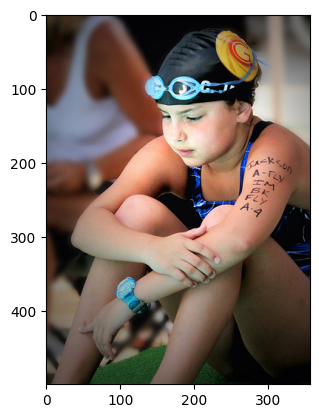

In [35]:
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
print(image)
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
caption,result,attention_plot = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

for i in caption:
    if i=="<unk>":
        caption.remove(i)

for i in real_caption:
    if i=="<unk>":
        real_caption.remove(i)

result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]
real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = caption

score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
print(f"BLEU-4 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
print(f"BLEU-3 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
print(f"BLEU-2 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
print(f"BLEU-1 score: {score*100}")
print ('Real Caption:', real_caption)
print ('Predicted Caption:', ' '.join(caption))
temp_image = np.array(Image.open(image))
plt.imshow(temp_image)

/kaggle/working/images/2273591668_069dcb4641.jpg
BLEU-4 score: 42.857142857142854
BLEU-3 score: 26.726124191242434
BLEU-2 score: 45.30661222656876
BLEU-1 score: 51.697315395717055
Real Caption: দুটি বাদামী কুকুর একটি খেলনা নিয়ে দৌড়াচ্ছে
Predicted Caption: দুটি কুকুর একটি মুখে গাছের পাশে সবুজ


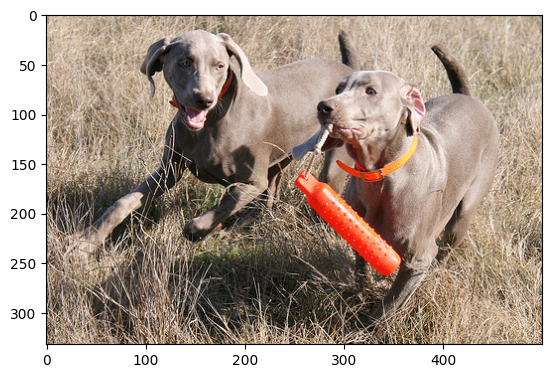

In [36]:
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
print(image)
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
caption,result,attention_plot = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

for i in caption:
    if i=="<unk>":
        caption.remove(i)

for i in real_caption:
    if i=="<unk>":
        real_caption.remove(i)

result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]
real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = caption

score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
print(f"BLEU-4 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
print(f"BLEU-3 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
print(f"BLEU-2 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
print(f"BLEU-1 score: {score*100}")
print ('Real Caption:', real_caption)
print ('Predicted Caption:', ' '.join(caption))
temp_image = np.array(Image.open(image))
plt.imshow(temp_image)

/kaggle/working/images/3034585889_388d6ffcc0.jpg
BLEU-4 score: 8.300915602566022
BLEU-3 score: 27.531022470118398
BLEU-2 score: 44.47345584091259
BLEU-1 score: 50.138404778620725
Real Caption: একজন মোটরসাইকেল আরোহী অন্য একজন <unk> <unk> মোটরসাইকেল আরোহীর দিকে তাকিয়ে আছে
Predicted Caption: একটি মোটরসাইকেল পিছনের চাকা শূন্যে উঠিয়ে দর্শকদের সামনে দিয়ে ছুটে যাচ্ছে


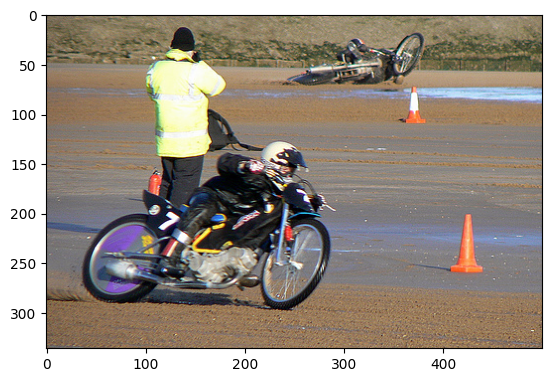

In [37]:
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
print(image)
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
caption,result,attention_plot = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

for i in caption:
    if i=="<unk>":
        caption.remove(i)

for i in real_caption:
    if i=="<unk>":
        real_caption.remove(i)

result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]
real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = caption

score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
print(f"BLEU-4 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
print(f"BLEU-3 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
print(f"BLEU-2 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
print(f"BLEU-1 score: {score*100}")
print ('Real Caption:', real_caption)
print ('Predicted Caption:', ' '.join(caption))
temp_image = np.array(Image.open(image))
plt.imshow(temp_image)

/kaggle/working/images/2428275562_4bde2bc5ea.jpg
BLEU-4 score: 38.94003915357025
BLEU-3 score: 36.05147093430547
BLEU-2 score: 35.284825080364236
BLEU-1 score: 26.924761780320416
Real Caption: একটি সাদা কালো কুকুর লাল গলা বন্ধনী পরে মাটি খুড়ছে
Predicted Caption: একটি সাদা কালো কুকুর বালির ঢিবির উপর দৌড়াচ্ছে


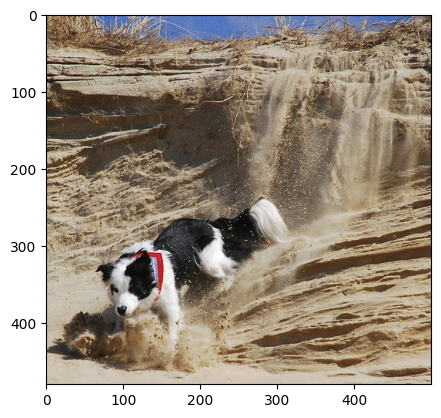

In [38]:
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
print(image)
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
caption,result,attention_plot = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

for i in caption:
    if i=="<unk>":
        caption.remove(i)

for i in real_caption:
    if i=="<unk>":
        real_caption.remove(i)

result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]
real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = caption

score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
print(f"BLEU-4 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
print(f"BLEU-3 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
print(f"BLEU-2 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
print(f"BLEU-1 score: {score*100}")
print ('Real Caption:', real_caption)
print ('Predicted Caption:', ' '.join(caption))
temp_image = np.array(Image.open(image))
plt.imshow(temp_image)

/kaggle/working/images/3457364788_3514a52091.jpg
BLEU-4 score: 0
BLEU-3 score: 0
BLEU-2 score: 0
BLEU-1 score: 0
Real Caption: একলোকের ঘাড়ে একটি ছোট্ট মেয়ে
Predicted Caption: একজন লোক তার বাচ্চাকে বাতাসে কাঁধে নিয়ে আছে


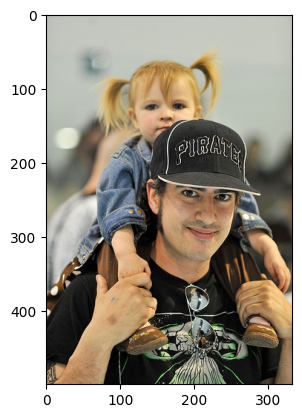

In [39]:
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
print(image)
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
caption,result,attention_plot = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

for i in caption:
    if i=="<unk>":
        caption.remove(i)

for i in real_caption:
    if i=="<unk>":
        real_caption.remove(i)

result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]
real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = caption

score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
print(f"BLEU-4 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
print(f"BLEU-3 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
print(f"BLEU-2 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
print(f"BLEU-1 score: {score*100}")
print ('Real Caption:', real_caption)
print ('Predicted Caption:', ' '.join(caption))
temp_image = np.array(Image.open(image))
plt.imshow(temp_image)

/kaggle/working/images/733752482_ee01a419e5.jpg
BLEU-4 score: 0
BLEU-3 score: 0
BLEU-2 score: 0
BLEU-1 score: 0
Real Caption: জিভ বের করে এক বাদামী কুকুরটির ক্লোজআপ।
Predicted Caption: একটি কুকুর ঘাসের উপর দৌড়াচ্ছে


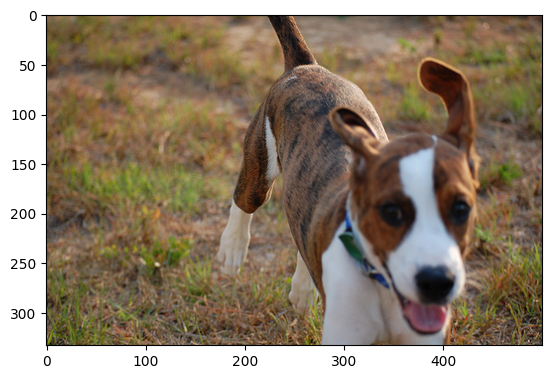

In [40]:
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
print(image)
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
caption,result,attention_plot = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

for i in caption:
    if i=="<unk>":
        caption.remove(i)

for i in real_caption:
    if i=="<unk>":
        real_caption.remove(i)

result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]
real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = caption

score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
print(f"BLEU-4 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
print(f"BLEU-3 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
print(f"BLEU-2 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
print(f"BLEU-1 score: {score*100}")
print ('Real Caption:', real_caption)
print ('Predicted Caption:', ' '.join(caption))
temp_image = np.array(Image.open(image))
plt.imshow(temp_image)

/kaggle/working/images/2726262796_03bd63a155.jpg
BLEU-4 score: 12.04776847648808
BLEU-3 score: 9.524597277019774
BLEU-2 score: 15.095469385282295
BLEU-1 score: 16.93739522663705
Real Caption: নীল রঙের গোসলের পোশাক পরিহিত একজন তরুণী সমুদ্রের ঢেউয়ে খেলা করছে
Predicted Caption: এক মেয়ে সমুদ্রের ঢেউয়ে দৌড়াচ্ছে


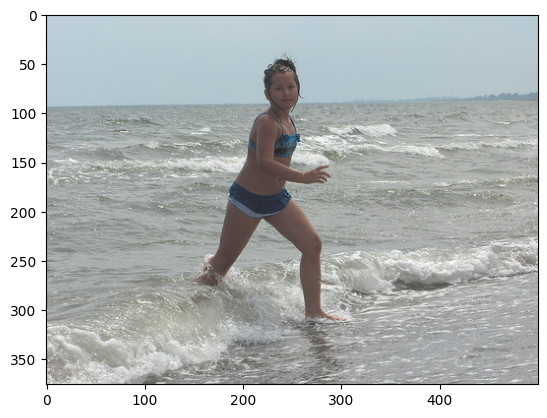

In [41]:
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
print(image)
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
caption,result,attention_plot = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

for i in caption:
    if i=="<unk>":
        caption.remove(i)

for i in real_caption:
    if i=="<unk>":
        real_caption.remove(i)

result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]
real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = caption

score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
print(f"BLEU-4 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
print(f"BLEU-3 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
print(f"BLEU-2 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
print(f"BLEU-1 score: {score*100}")
print ('Real Caption:', real_caption)
print ('Predicted Caption:', ' '.join(caption))
temp_image = np.array(Image.open(image))
plt.imshow(temp_image)

/kaggle/working/images/2478929971_9eb6c074b6.jpg
BLEU-4 score: 12.383969996431167
BLEU-3 score: 32.76490485424231
BLEU-2 score: 48.35356722608987
BLEU-1 score: 53.294626282168544
Real Caption: ছয়টি বাচ্চা একটি <unk> সবুজ গাছের ছায়ায় আছে।
Predicted Caption: একদল লোক বাইরে একটি ইটের দালানের সামনে


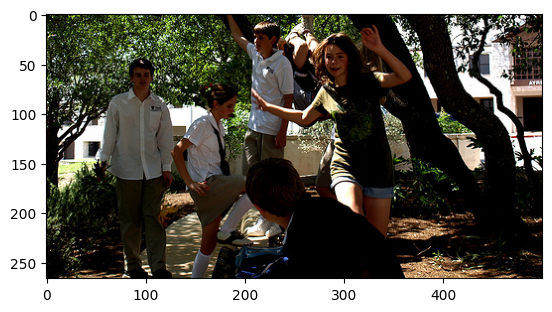

In [42]:
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
print(image)
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
caption,result,attention_plot = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

for i in caption:
    if i=="<unk>":
        caption.remove(i)

for i in real_caption:
    if i=="<unk>":
        real_caption.remove(i)

result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]
real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = caption

score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
print(f"BLEU-4 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
print(f"BLEU-3 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
print(f"BLEU-2 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
print(f"BLEU-1 score: {score*100}")
print ('Real Caption:', real_caption)
print ('Predicted Caption:', ' '.join(caption))
temp_image = np.array(Image.open(image))
plt.imshow(temp_image)

/kaggle/working/images/248174959_2522871152.jpg
BLEU-4 score: 28.57142857142857
BLEU-3 score: 14.824986333222023
BLEU-2 score: 31.812410730759733
BLEU-1 score: 38.503228868787126
Real Caption: লাল শার্টের এক মহিলা একটি উঁচু পাহাড়ের কিনারে বসে আছে।
Predicted Caption: একটি বড় গোলাপি এবং হলুদ জামা পরা মহিলা সবুজ রঙের একটি টেবিলে বসে আছে।


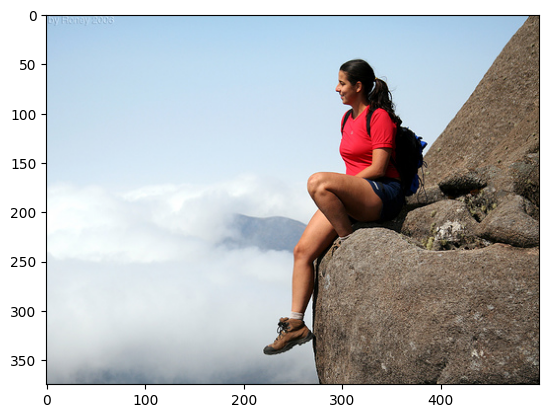

In [43]:
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
print(image)
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
caption,result,attention_plot = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

for i in caption:
    if i=="<unk>":
        caption.remove(i)

for i in real_caption:
    if i=="<unk>":
        real_caption.remove(i)

result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]
real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = caption

score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
print(f"BLEU-4 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
print(f"BLEU-3 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
print(f"BLEU-2 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
print(f"BLEU-1 score: {score*100}")
print ('Real Caption:', real_caption)
print ('Predicted Caption:', ' '.join(caption))
temp_image = np.array(Image.open(image))
plt.imshow(temp_image)

In [44]:
data_ref=[]
data_gen=[]
cnt=0
for j in range(len(img_name_val)):
    image = img_name_val[j]
    real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[j] if i not in [0]])
    caption,result,attention_plot = evaluate(image)
    first = real_caption.split(' ', 1)[1]
    real_caption = first.rsplit(' ', 1)[0]

    for i in caption:
        if i=="<unk>":
            caption.remove(i)

    for i in real_caption:
        if i=="<unk>":
            real_caption.remove(i)

    result_join = ' '.join(caption)
    result_final = result_join.rsplit(' ', 1)[0]
    real_appn = []
    real_appn.append(real_caption.split())
    reference = real_appn
    candidate = caption 
    # Convert the list to a string
    reference = ' '.join([' '.join(lst) for lst in reference])
    # Convert the list of words to a space-separated string
    candidate = ' '.join(candidate)
    if(len(candidate.split())>25 or len(reference.split())>25):
        continue
    data_ref.append(reference)
    data_gen.append(candidate)
    cnt +=1

print("cnt=",cnt)
    
# Specify the file name
file_name1 = "convnexttiny_reference.txt"  

# Create and write data from the list to the text file in the working directory
with open(file_name1, "w") as file:
    for item in data_ref:
        file.write(item + "\n")

print(f"Data from the list written to {file_name1} successfully.")

# Specify the file name
file_name2 = "convnexttiny_candidate.txt"  

# Create and write data from the list to the text file in the working directory
with open(file_name2, "w") as file:
    for item in data_gen:
        file.write(item + "\n")

print(f"Data from the list written to {file_name2} successfully.")

cnt= 767
Data from the list written to convnexttiny_reference.txt successfully.
Data from the list written to convnexttiny_candidate.txt successfully.


In [45]:
#Bleu score 
bleu_1=[]
bleu_2=[]
bleu_3=[]
bleu_4=[]
cnt=0
for j in range(len(img_name_val)):
    image = img_name_val[j]
    real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[j] if i not in [0]])
    caption,result,attention_plot = evaluate(image)
    first = real_caption.split(' ', 1)[1]
    real_caption = first.rsplit(' ', 1)[0]

    for i in caption:
        if i=="<unk>":
            caption.remove(i)

    for i in real_caption:
        if i=="<unk>":
            real_caption.remove(i)

    result_join = ' '.join(caption)
    result_final = result_join.rsplit(' ', 1)[0]
    real_appn = []
    real_appn.append(real_caption.split())
    reference = real_appn
    candidate = caption

    score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
    BLEU_1 =score*100
    score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
    BLEU_2 =score*100
    score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
    BLEU_3 =score*100
    score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
    BLEU_4 =score*100
    if BLEU_4>=50:
        bleu_1.append(BLEU_1)
        bleu_2.append(BLEU_2)
        bleu_3.append(BLEU_3)
        bleu_4.append(BLEU_4)
        cnt +=1
        
sum_bleu1 =sum(bleu_1)
sum_bleu2 =sum(bleu_2)
sum_bleu3 =sum(bleu_3)
sum_bleu4 =sum(bleu_4)
print("Total caption is : ",cnt)
print(f"Avarage BLEU-1 score: {sum_bleu4/cnt}")
print(f"Avarage BLEU-2 score: {sum_bleu3/cnt}")
print(f"Avarage BLEU-3 score: {sum_bleu2/cnt}")
print(f"Avarage BLEU-4 score: {sum_bleu1/cnt}")

Total caption is :  291
Avarage BLEU-1 score: 60.57625568685133
Avarage BLEU-2 score: 55.64715867905153
Avarage BLEU-3 score: 40.11340595797964
Avarage BLEU-4 score: 20.861033778905558
